external_array.npy must have the same shape as the input to the model, and have the same number of parameters as the model was trained on.  
For example, the third dimension (inner most array) carries each paramter for a specific time:  
foo = [[['p10', 'p20'], ['p11', 'p21'],['p12', 'p22'] ,['p13', 'p23']]]  
  
The sample rate and length in seconds are up to you, and must be provided in the arguments to generate.py  

The notebook is just an assortment of different routines for creating patterns of parameters. for playing note arpeggios, melodies, or gliding around a 2D space to test the generative capabilities of the RNN.

If you just run all the cells, the  #step glide  code segment will run to generate the param file, then read the file and plot the parameters.  

If you want to generate LOTS of files, each with different constant parmeter values, see the companion notebook, 
MakeConditioningParamFiles.ipynb


In [6]:
# parameters
condsr = 1000 # the sample rate for the generated array to pass to generate.py
numsecs = 1 # number of seconds to generate
numDataPoints=numsecs*condsr

In [7]:
# save numpy array as npy file
import numpy as np
from numpy import asarray
from numpy import save
# define data
# data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

from matplotlib import pyplot as plt


In [8]:
#utility
def map(x,a,b,m,n) :
    return m + (n-m)*(x-a)/(b-a)

In [10]:
# for plotting in time
t_values = np.linspace(0, numsecs, numDataPoints) #linspace is inclusive of endpoints


In [11]:
# functions for conditioning parameter gestures
# These control sequences get upsampled to audiosr in the generate.py code, so don't need high sr here.
def linear(x, m, b=0) :
    return m*x+b  

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def step(x, a, b, m, n, numsteps) :  # 1 means function in constant, 
    assert numsteps > 0
    stepLen=(b-a)/numsteps
    stepNum=(x-a)//stepLen
    stepHeight=467 if (numsteps == 0) else (n-m)/(numsteps-1)
    return m+stepNum*stepHeight


'''
arr elements must be in [plow, phigh] 
'''
def normedValSeq(arr, plow, phigh, samps) :
    farr=[(n-plow)/(phigh-plow) for n in arr]
    alen=len(farr)
    fsampspernote=samps/alen
    # each note will have an duration equal to the rest within 1 sample
    return [farr[int((n)//fsampspernote)] for n in range(samps)]

'''
This creates a sequence of length sum(durseq), where each element in shorseq 
is duplicated by the correspeonding number in durseq.
'''
def spread(shortseq,durseq) :
    out=np.empty(0)
    for n in range(len(durseq)) :
        out = np.append(out, np.full(durseq[n],shortseq[n]))
    return out


'''
This creates a sequence of linear 0-1 interpolates of durations specified by durseq.
'''
def envSeq(durseq) :
    out=np.empty(0)
    for n in range(len(durseq)) :
        out = np.append(out, np.linspace(0,1,durseq[n],True))
    return out
        

<img src="resources/rhapsody.jpeg">

We have notes 56-76. We'll call that high 'c' 76, so the ending 'g' is 59. So:
59-(glide)76 [2] 79[2 tr] 74[.3] 72[.3] 74[.3] 72[.3] 74[.3] 72[.3] |   
71[.5] 69[.5] 68[.5] 67[1] 69[.5] 70[.5] 71[1]  
68[.5] 64[.25] 66[.25] 64[.25] 63[.25] 62[1] 60[.5] 59[.5] 59[3.5]

In [135]:
def rblueextended(t) :
    if t < 2 : 
        tt=map(t,0,2,0,2)
        return 59+(1+np.cos(np.pi*2*(1.5*tt*tt)))
    if t < 4 :
        return map(t,2,4,59,76)
    if t < 6 :
        tt=map(t,4,6,0,1)
        return 76+(-1+np.cos(np.pi*2*(3*tt*tt)))
    if t < 6.3333 :
        return 74
    if t < 6.6666 :
        return 72
    if t < 7 :
        return 74
    if t < 7.3333 :
        return 72
    if t < 7.6666 :
        return 74
    if t < 8 :
        return 72
    
    # measure 2
    if t < 8.5 :
        return 71
    if t < 9 :
        return 69
    if t < 9.5 :
        return 68
    if t < 10.5 : #tied
        return 67
    if t < 11 :
        return 69 #(e natural)
    if t < 11.5 :
        return 70
    if t < 12.5 : #tied
        return 71
    if t < 13 :
        # 68[.5] 
        return 68  #eb
    if t < 13.125 : 
        #64[.25] 
        return 64
    if t < 13.25 : 
        #66[.25] 
        return 66
    if t < 13.375 : 
        #64[.25] 
        return 64
    if t < 13.5 : 
        #63[.25] 
        return 63
    if t < 14.5 : 
        #62[1] 
        return 62
    if t < 15 : 
        #60[.5] 59[.5] 59[3.5]
        return 60
    if t < 15.5 : 
        #59[.5] 
        return 59
    if t < 17 : 
        return 59
    if t<=19 :
        tt=map(t,17,19,0,1)
        return 59+.5*np.sin(np.pi*2*(4*tt)) # .35*(1-np.cos(np.pi*2*(2*tt)))


In [136]:
# 76 Bb (We are transposing Rhapsody in blue  from Bb to E!)
# 75 A
# 74 Ab
# 73 G
# 72 
# 71 F
# 70 
# 69 Eb
# 68 D
# 67 
# 66 C
# 65 
# 64 Bb
# Rhapsody in Blue
def rblue(t) :
    if t < 2 :
        return map(t,0,2,64,76)
    if t < 4 :
        tt=map(t,2,4,0,1)
        return 76+(-1+np.cos(np.pi*2*(4.5*tt*tt)))
    if t < 4.3333 :
        return 74
    if t < 4.6666 :
        return 72
    if t < 5 :
        return 74
    if t < 5.3333 :
        return 72
    if t < 5.6666 :
        return 74
    if t < 6 :
        return 72
    
    # measure 2
    if t < 6.5 :
        return 71
    if t < 7 :
        return 69
    if t < 7.5 :
        return 68
    if t < 8.5 : #tied
        return 67
    if t < 9 :
        return 69
    if t < 9.5 :
        return 70
    if t < 10.5 : #tied
        return 71
    if t < 11 :
        return 68
    if t < 11.5 :
        return 66
    tt=map(t,12,14,0,1)
    return 64+.15*np.sin(np.pi*2*(4*tt)) # .35*(1-np.cos(np.pi*2*(2*tt)))
    
        
        

In [137]:
if False :
    # map t_values to x_values to pass to your function
    #   or just create your x_values to have the same length as t_values

    #x_values=[map(item,0,numsecs,0, 1) for item in t_values]
    #x_values = np.linspace(0, 1, numDataPoints) #linspace is inclusive of endpoints
    #data = [linear(x, -1,1) for x in x_values]


    #x_values=[map(item,0,numsecs,-3, 3) for item in t_values]
    #x_values = np.linspace(-3,  3, numDataPoints) #linspace is inclusive of endpoints
    #data = [[[gaussian(x, 0, 1)] for x in x_values]]

    #x_values = np.linspace(0,  1, numDataPoints, endpoint = False) #linspace is b default inclusive of endpoints
    #data = [[[step(x, 0, 1, -6,6,3)] for x in x_values]]

    #  CONSTANT
    #data = [[[aparam] for t in t_values]]

    ###########################  2D #######################################
    # one gausian, one constant
    #x_values = np.linspace(-3,  3, numDataPoints) #linspace is inclusive of endpoints
    #data = [[[.5, gaussian(x, 0, 1)] for x in x_values]]

    # both constant
    #for vibrato, p1 is vibrato, and p2 is depth
    #data = [[[.47, 1] for x in x_values]]   #because of that damn nonlinear scaling we used for vibrato
    #data = [[[1, .47] for x in x_values]]

    ###########################  3D #######################################
    #x_values = np.linspace(-3,  3, numDataPoints) #linspace is inclusive of endpoints
    #data = [[[1,.8, gaussian(x, 0, 1)] for x in x_values]]


    #===========================================================================================
    # rhapsody1
    noteseq=[rblue(t) for t in np.linspace(0, 14, numDataPoints)]
    normedValSeq=normedValSeq(noteseq,64,76,numDataPoints)
    d0=np.array([ normedValSeq[i] for i in range(numDataPoints)])
    d1=(np.linspace(0,1, numDataPoints, True))
    data = [np.stack((d0,d1), 1)]
    outdir = 'scratch/rhapsody_1000samps.npy' # the file name for the generated array to pass to generate.py
    #===========================================================================================
    # rhapsody2
    noteseq=[rblueextended(t) for t in np.linspace(0, 19, numDataPoints)]
    normedValSeq=normedValSeq(noteseq,56,76,numDataPoints)
    d0=np.array([ normedValSeq[i] for i in range(numDataPoints)])
    d1=(np.linspace(1,0, numDataPoints, True))
    data = [np.stack((d0,d1), 1)]
    outdir = 'scratch/rhapsody2_extended_1000samps.npy' # the file name for the generated array to pass to generate.py


if False :
# Responsiveness tests
    # -- arpeggio up glide down
    noteseq=[64,68,71,76]
    normedValSeq=normedValSeq(noteseq,64,76,int(numDataPoints/2))
    sampledseq=np.array([normedValSeq[i] for i in range(int(numDataPoints/2))])
    #print(f"sampledseq = {sampledseq}")
    #print(f"linspace = {np.linspace(1,0, int(numDataPoints/2), False)}")
    d0=np.concatenate((sampledseq, np.linspace(1,0, int(numDataPoints/2), False)))
    data=[[[ d0[i],0] for i in range(numDataPoints)]]
    outdir = 'scratch/responseiveness_i0.arpeggio_then_glide.npy'
    
    #step glide
    noteseq=[71]
    normedValSeq=normedValSeq(noteseq,64,76,int(numDataPoints))
    sampledseq=np.array([normedValSeq[i] for i in range(numDataPoints)])
    d1=np.concatenate((np.linspace(0,0, int(numDataPoints/8), False), np.linspace(1,1,int(numDataPoints/4),False), np.linspace(0,0, int(numDataPoints/8), False), np.linspace(0,1,int(numDataPoints/4),False), np.linspace(1,0,int(numDataPoints/4),False)))
    data=[[[ sampledseq[i],d1[i]] for i in range(numDataPoints)]]
    outdir = 'scratch/responseiveness_inst_step_then_glide.npy'
    save(outdir, data)

#V  pitch glide
timbre=0
timbreSeq=[timbre]
normedValSeq=normedValSeq(timbreSeq,0,1,int(numDataPoints))
sampledseq=np.array([normedValSeq[i] for i in range(numDataPoints)])

lownote=map(60,56,76,0,1)
hinote=map(72,56,76,0,1)

d1=np.concatenate((np.linspace(lownote,hinote, int(numDataPoints/2), False), np.linspace(hinote,lownote,int(numDataPoints/2),True)))
data=[[[d1[i],sampledseq[i]] for i in range(numDataPoints)]]
outdir = f'scratch/p0.vglide.2-.8-.2_p1.{timbre}_.npy'
save(outdir, data)

if False : 
    #V  Timbre glide
    note=map(67,56,76,0,1)
    noteSeq=[note]
    normedValSeq=normedValSeq(noteSeq,0,1,int(numDataPoints))
    sampledseq=np.array([normedValSeq[i] for i in range(numDataPoints)])


    d0=np.concatenate((np.linspace(0,1, int(numDataPoints/2), False), np.linspace(1,0,int(numDataPoints/2),True)))
    data=[[[sampledseq[i], d0[i]] for i in range(numDataPoints)]]
    outdir = f'scratch/p0.{note}_p1.vglide.0-1-0_.npy'
    save(outdir, data)



   
    ###########################  ganSynth #######################################
    noteseq=np.array([64,68,71,76,71,68,64])-6
    sdurseq=[int(numDataPoints//8) for n in range(len(noteseq))]
    sdurseq[-1]=numDataPoints-sum(sdurseq[:-1])
    normedValSeq=spread([map(n,58,70,0,1) for n in noteseq], sdurseq) 
    envPts=envSeq(sdurseq)
    instIDs=np.linspace(0,1,numDataPoints,True)
    # data=[[[instIDs[i], envPts[i], normedValSeq[i]] for i in range(numDataPoints)]]
    # instrument 0
    #data=[[[0, envPts[i], normedValSeq[i]] for i in range(numDataPoints)]]
    #instrument 1
    #data=[[[1, envPts[i], normedValSeq[i]] for i in range(numDataPoints)]]
    #instrument 1, constant env=.3
    #data=[[[1,.3, normedValSeq[i]] for i in range(numDataPoints)]]

    # w/o envPts
    #data=[[[1,  normedValSeq[i]] for i in range(numDataPoints)]]
    data=[[[instIDs[i], normedValSeq[i]] for i in range(numDataPoints)]]

    ########################### oreilly #######################################
    # four courners discrete at (0,0) to (1,0), to (1,1) to (0,1) 
    # go around clockwise
    sidelen=numDataPoints//4
    d0=np.concatenate((np.linspace(0,0, sidelen, False), np.linspace(1,1,sidelen,False), np.linspace(1,1,sidelen,False), np.linspace(0,0,sidelen,False)))
    d1=np.concatenate((np.linspace(0,0, sidelen, False), np.linspace(0,0,sidelen,False), np.linspace(1,1,sidelen,False), np.linspace(1,1,sidelen,False)))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/discretefourcorners_1000samps.npy"

    # -- arpeggio
    noteseq=[64,68,71,76,71,68,64,64]
    normedValSeq=normedValSeq(noteseq,64,76,numDataPoints)
    #data=[[[aparam, .8, normedValSeq[i]] for i in range(numDataPoints)]]
    data=[[[ normedValSeq[i],1] for i in range(numDataPoints)]]
    outdir = 'scratch/i1.arpeggio.npy'



    # 4 corners contant --------------------------
    # note d1 row, d0 is columns 

    d1=np.zeros((numDataPoints))
    d0=np.zeros((numDataPoints))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/fourcorners_c00.npy"
    save(outdir, data)

    d1=np.zeros((numDataPoints))
    d0=np.ones((numDataPoints))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/fourcorners_c01.npy"
    save(outdir, data)

    d1=np.ones((numDataPoints))
    d0=np.ones((numDataPoints))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/fourcorners_c11.npy"
    save(outdir, data)

    d1=np.ones((numDataPoints))
    d0=np.zeros((numDataPoints))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/fourcorners_c10.npy"
    save(outdir, data)
    # 4 corners contant --------------------------



    # four courners gliding line from (0,0) to (1,0), to (1,1) to (0,1) and back to (0,0)
    sidelen=numDataPoints//4
    d0=np.concatenate((np.linspace(0,1, sidelen, False), np.linspace(1,1,sidelen,False), np.linspace(1,0,sidelen,False), np.linspace(0,0,sidelen,False)))
    d1=np.concatenate((np.linspace(0,0, sidelen, False), np.linspace(0,1,sidelen,False), np.linspace(1,1,sidelen,False), np.linspace(1,0,sidelen,False)))
    data = [np.stack((d0,d1), 1)]
    outdir = "scratch/glidefourcorners_1000samps.npy"



    #2d sin explore
    d1=(np.linspace(0,1, numDataPoints, True))
    d0=(1+np.cos(d1*np.pi*2*5))/2
    data = [np.stack((d0,d1), 1)]
    outdir = 'scratch/linVsin_1000samps.npy' # the file name for the generated array to pass to generate.py


In [138]:
# save to npy file
save(outdir, data)

## Test our saved parameter file

In [13]:
outdir='scratch/p0.vglide.2-.8-.2_p1.1_.npy'
#test
# load numpy array from npy file
from numpy import load
# load array
datain = load(outdir)
#datain=load('scratch/GANsynthArpeggio_basic_1000samps.npy')
numParams=len(datain[0,0])
numParams

2

In [14]:
datain

array([[[0.2       , 1.        ],
        [0.2012    , 1.        ],
        [0.2024    , 1.        ],
        ...,
        [0.20240481, 1.        ],
        [0.2012024 , 1.        ],
        [0.2       , 1.        ]]])

In [15]:
datain.shape

(1, 1000, 2)

In [16]:
datain[0,0]

array([0.2, 1. ])

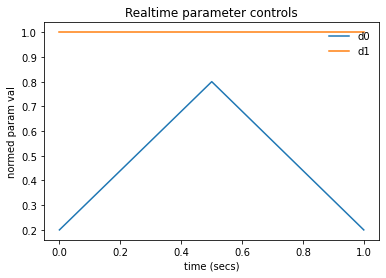

In [17]:
fig, ax = plt.subplots()

for pnum in range(numParams) :
    ax.plot(t_values, datain[0,:,pnum], label='d'+str(pnum))
    
#ax.plot(y, color='blue')
#ax.plot(z, color='black')
ax.legend(loc='upper right', frameon=False)
plt.xlabel("time (secs)")
plt.ylabel("normed param val")
plt.title("Realtime parameter controls")
plt.show()